# Advanced Geopandas
<img src="https://miro.medium.com/max/3720/1*HevTonUoRkTNolFPO2P8Kw.png" width=450>
Use Pysal to classify data, download vector data from Open Street Maps.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-reclassification" data-toc-modified-id="Data-reclassification-1">Data reclassification</a></span><ul class="toc-item"><li><span><a href="#Visualize-travel-times-on-map" data-toc-modified-id="Visualize-travel-times-on-map-1.1">Visualize travel times on map</a></span></li></ul></li><li><span><a href="#Classify-with-Pysal" data-toc-modified-id="Classify-with-Pysal-2">Classify with Pysal</a></span><ul class="toc-item"><li><span><a href="#Custom-classifier" data-toc-modified-id="Custom-classifier-2.1">Custom classifier</a></span></li></ul></li><li><span><a href="#Download-from-OSM" data-toc-modified-id="Download-from-OSM-3">Download from OSM</a></span><ul class="toc-item"><li><span><a href="#Convert-DiGraph-to-GeoDataFrame" data-toc-modified-id="Convert-DiGraph-to-GeoDataFrame-3.1">Convert DiGraph to GeoDataFrame</a></span></li><li><span><a href="#Download-buildings-from-OSM" data-toc-modified-id="Download-buildings-from-OSM-3.2">Download buildings from OSM</a></span></li><li><span><a href="#Plot-on-map" data-toc-modified-id="Plot-on-map-3.3">Plot on map</a></span></li></ul></li></ul></div>

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

## Data reclassification
This is the process of grouping data into set intervals or classes. The class intervals can be manually set or a classification scheme (such as Natural Breaks (Jenks), Quantiles, equal interval..) can be used.

In [2]:
helsinki_traveltimes = gpd.read_file('./data/travel_times/travel_times_overlay_helsinki.geojson')
helsinki_traveltimes.head(3)

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,15981,36,15988,41,6002702,14698,65,73,14698,61,72,5975375,14456,207,27517366,Helsinki,Helsingfors,091,"POLYGON ((391000.0001349226 6667750.00004299, ..."
1,16190,34,16197,39,6002701,14661,64,73,14661,60,72,5975375,14419,206,27517366,Helsinki,Helsingfors,091,"POLYGON ((390750.0001349644 6668000.000042951,..."
2,15727,33,15733,37,6001132,14256,59,69,14256,55,62,5975375,14014,200,27517366,Helsinki,Helsingfors,091,"POLYGON ((391000.0001349143 6668000.000042943,..."


The `pt_r_tt` column contains time taken to reach city center. The `walk_d` column is the network distance to city center.

In [3]:
# remove bad values, no data values
helsinki_traveltimes = helsinki_traveltimes[helsinki_traveltimes['pt_r_tt'] > 0]

### Visualize travel times on map

Text(0.5,1,'Travel times to city center')

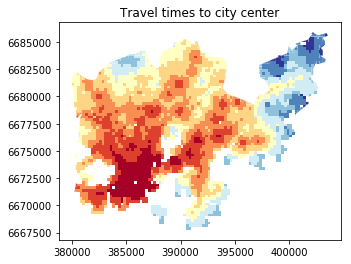

In [4]:
helsinki_traveltimes.plot(column='pt_r_tt', scheme='Fisher_Jenks',
                         k=9, cmap='RdYlBu', linewidth=0)
# scheme is the classification scheme
# k=9 represents 9 classes in the scheme
# cmap is Red, Yellow, Blue transitions

plt.title('Travel times to city center')

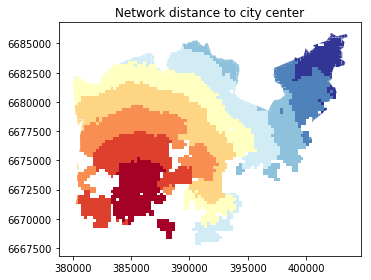

In [5]:
helsinki_traveltimes.plot(column='walk_d', scheme='Fisher_Jenks',
                         k=9, cmap='RdYlBu', linewidth=0)
# scheme is the classification scheme
# k=9 represents 9 classes in the scheme
# cmap is Red, Yellow, Blue transitions

plt.title('Network distance to city center')
plt.tight_layout()

## Classify with Pysal

In [6]:
import pysal as ps
n_classes = 9

Create a classifier object that can be used with `apply()` method of the `DataFrame` object. There are two ways to classify this. One is to send data to Pysal and classify, the other is to get a classifier function and use that to iterate over the rows of the data frame. As you expect, we will do the latter.

The `make()` method of the `Natural_Breaks` class is like a partial constructor. It accepts all parameters of the constructor other than the full data

In [7]:
nb_classifier = ps.esda.mapclassify.Natural_Breaks.make(k=n_classes)
type(nb_classifier)

function

In [15]:
classification = helsinki_traveltimes[['pt_r_tt']].apply(nb_classifier)

In [17]:
classification.head()

,pt_r_tt
0,7
1,7
2,6
3,7
4,7


Thus we have classified the time to city center into `9` classes. The `Natural Breaks` classifier iterates over the whole data making `n_classes` groups such that the **variability within groups is minimum** and **variability between groups** is higher.

In [19]:
# rename the column
classification.rename(columns={'pt_r_tt':'nb_pt_r_tt'}, inplace=True)

In [21]:
classification.head()

,nb_pt_r_tt
0,7
1,7
2,6
3,7
4,7


Join with original geodataframe

In [24]:
helsinki_traveltimes.join(classification, how='outer')
helsinki_traveltimes.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry
0,15981,36,15988,41,6002702,14698,65,73,14698,61,72,5975375,14456,207,27517366,Helsinki,Helsingfors,091,"POLYGON ((391000.0001349226 6667750.00004299, ..."
1,16190,34,16197,39,6002701,14661,64,73,14661,60,72,5975375,14419,206,27517366,Helsinki,Helsingfors,091,"POLYGON ((390750.0001349644 6668000.000042951,..."
2,15727,33,15733,37,6001132,14256,59,69,14256,55,62,5975375,14014,200,27517366,Helsinki,Helsingfors,091,"POLYGON ((391000.0001349143 6668000.000042943,..."
3,15975,33,15982,37,6001131,14512,62,73,14512,58,70,5975375,14270,204,27517366,Helsinki,Helsingfors,091,"POLYGON ((390750.0001349644 6668000.000042951,..."
4,16136,35,16143,40,6001138,14730,65,73,14730,61,72,5975375,14212,203,27517366,Helsinki,Helsingfors,091,"POLYGON ((392500.0001346234 6668000.000042901,..."


In [25]:
helsinki_traveltimes.columns

Index(['car_m_d', 'car_m_t', 'car_r_d', 'car_r_t', 'from_id', 'pt_m_d',
       'pt_m_t', 'pt_m_tt', 'pt_r_d', 'pt_r_t', 'pt_r_tt', 'to_id', 'walk_d',
       'walk_t', 'GML_ID', 'NAMEFIN', 'NAMESWE', 'NATCODE', 'geometry'],
      dtype='object')

### Custom classifier
We can define our own classifier as a function and do the rest as in regular pandas

In [42]:
# find places that are within 20 mins of drive time, but at least 5 KM away from city
# center
def binary_classifier(row):
    if row['pt_r_tt'] <= 20 and row['walk_d'] >= 4000:
        return 1
    else:
        return 0

In [43]:
# time this classification
%time

# apply the classifier
helsinki_traveltimes['suitable_grid'] = helsinki_traveltimes.apply(binary_classifier, axis=1)

# see output
helsinki_traveltimes.head(5)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs


,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,geometry,suitable_grid
0,15981,36,15988,41,6002702,14698,65,73,14698,61,72,5975375,14456,207,27517366,Helsinki,Helsingfors,091,"POLYGON ((391000.0001349226 6667750.00004299, ...",0
1,16190,34,16197,39,6002701,14661,64,73,14661,60,72,5975375,14419,206,27517366,Helsinki,Helsingfors,091,"POLYGON ((390750.0001349644 6668000.000042951,...",0
2,15727,33,15733,37,6001132,14256,59,69,14256,55,62,5975375,14014,200,27517366,Helsinki,Helsingfors,091,"POLYGON ((391000.0001349143 6668000.000042943,...",0
3,15975,33,15982,37,6001131,14512,62,73,14512,58,70,5975375,14270,204,27517366,Helsinki,Helsingfors,091,"POLYGON ((390750.0001349644 6668000.000042951,...",0
4,16136,35,16143,40,6001138,14730,65,73,14730,61,72,5975375,14212,203,27517366,Helsinki,Helsingfors,091,"POLYGON ((392500.0001346234 6668000.000042901,...",0


In [62]:
helsinki_traveltimes.shape

(3816, 20)

In [44]:
helsinki_traveltimes['suitable_grid'].value_counts()

0    3794
1      22
Name: suitable_grid, dtype: int64

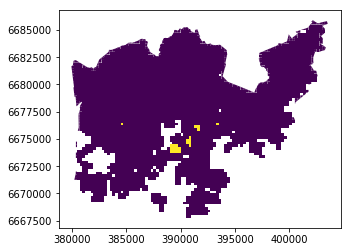

In [45]:
helsinki_traveltimes.plot(column='suitable_grid')

## Download from OSM
Use [OSMnx](https://github.com/gboeing/osmnx) library to download vector, network data from open streets maps server.

In [11]:
import osmnx as ox
chennai_graph = ox.graph_from_place('Chennai, Tamil Nadu, India')
type(chennai_graph)

networkx.classes.multidigraph.MultiDiGraph

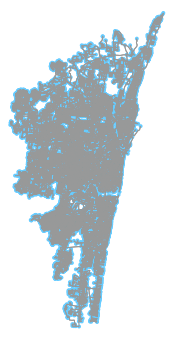

(<Figure size 216.459x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1542a5ecf8>)

In [15]:
ox.plot_graph(chennai_graph)

Chennai is quite large and it takes a long time. Let us try an address. OSMnx will apply a bound box around it and get the network around it.

In [17]:
redlands_graph = ox.graph_from_address('380 New York St, Redlands, CA, USA')

In [18]:
ox.plot_graph_folium(redlands_graph)

### Convert DiGraph to GeoDataFrame

In [20]:
redlands_nodes, redlands_edges = ox.graph_to_gdfs(redlands_graph)
redlands_nodes.head()

,highway,osmid,ref,x,y,geometry
54282058,traffic_signals,54282058,NaN,-117.2,34.0646,POINT (-117.2002004 34.0646087)
54307215,NaN,54307215,NaN,-117.201,34.0652,POINT (-117.2014769 34.0652388)
54310829,NaN,54310829,NaN,-117.198,34.052,POINT (-117.1978832 34.0519842)
54310830,turning_loop,54310830,NaN,-117.198,34.0511,POINT (-117.1979513 34.0511416)
54313777,motorway_junction,54313777,79,-117.191,34.0617,POINT (-117.1909685 34.0616596)


If you notice, the nodes are of `Point` geometry. I think these represent the intersections

In [21]:
redlands_edges.head()

,access,bridge,geometry,highway,key,lanes,length,maxspeed,name,oneway,osmid,ref,service,u,v
0,NaN,NaN,"LINESTRING (-117.200091 34.0592561, -117.19667...",residential,0,NaN,315.100,NaN,West Park Avenue,False,7512595,NaN,NaN,1235207168,2921241165
1,NaN,NaN,"LINESTRING (-117.200091 34.0592561, -117.20073...",residential,0,NaN,59.410,NaN,West Park Avenue,False,7512595,NaN,NaN,1235207168,4496777852
2,NaN,NaN,"LINESTRING (-117.200091 34.0592561, -117.20009...",tertiary,0,"[4, 5]",165.086,40 mph,Tennessee Street,False,"[237035432, 475113846]",NaN,NaN,1235207168,3844123278
3,NaN,NaN,"LINESTRING (-117.200091 34.0592561, -117.20008...",tertiary,0,"[4, 5]",199.419,40 mph,Tennessee Street,False,"[475113850, 475113854]",NaN,NaN,1235207168,3843278118
4,NaN,NaN,"LINESTRING (-117.1967853 34.0568395, -117.1967...",footway,0,NaN,13.175,NaN,NaN,False,380911240,NaN,NaN,1333960705,3842059569


The `edges` are of `linestring` geometry and a host of information.
### Download buildings from OSM

In [23]:
redlands_buildings = ox.buildings_from_address('380 New York St, Redlands, CA, USA',
                                              distance=1000)

In [24]:
type(redlands_buildings)

geopandas.geodataframe.GeoDataFrame

In [25]:
redlands_buildings.head()

,abutters,addr:city,addr:country,addr:housename,addr:housenumber,addr:postcode,addr:state,addr:street,alt_name,amenity,...,shop,smoking,source,source:address,source_ref,subject,tourism,website,wikidata,wikipedia
17005724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,bing_imagery_0.06m_200706,NaN,NaN,NaN,NaN,NaN,Q18393818,en:Redlands Mall
19787719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19787787,commercial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28147457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32194340,NaN,Redlands,US,ESRI HQ,350,92373,NaN,New York Street,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Plot on map

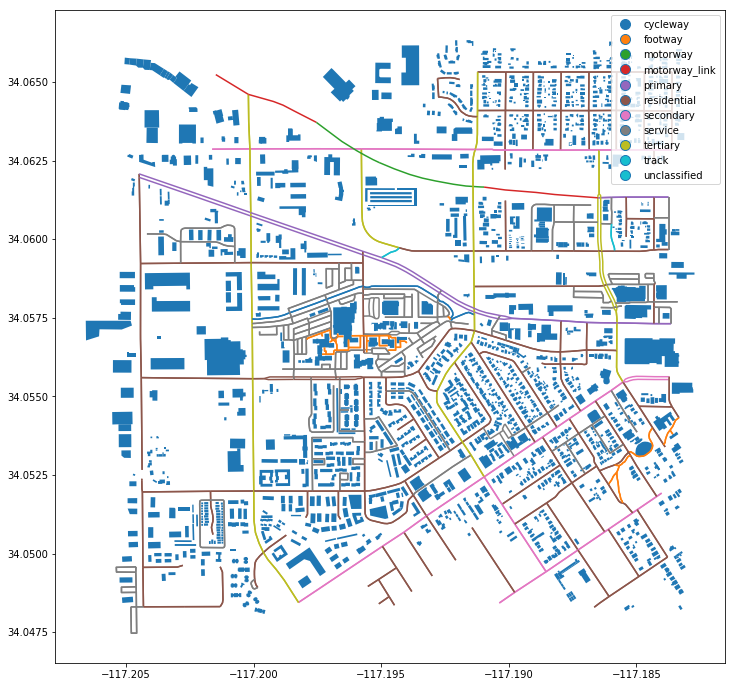

In [34]:
fig, ax = plt.subplots(figsize=(12,12))

# plot the streets, colored by the type of street
redlands_edges.plot(ax=ax, column='highway', legend=True)

# plot the buildings
redlands_buildings.plot(ax=ax)